# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [8]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM RawDataClean", engine)

In [9]:
df.head(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

### 2. Write a tokenization function to process your text data

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [11]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [428]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline

In [417]:
from tempfile import mkdtemp
# cachedir = mkdtemp()

base_lr = LogisticRegression()
# pipe = Pipeline([
#     ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
#     ('clf', OneVsRestClassifier(base_lr)),
# ], memory=cachedir)

pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', OneVsRestClassifier(base_lr)),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
from sklearn.model_selection import train_test_split
categories = df.drop(columns = ['id', 'message', 'original', 'genre'])
x, y = df['message'].to_numpy(), categories.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=0)
x_train.shape, y_train.shape, y.shape, x.shape

In [ ]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred, average='samples')
ovr_jaccard_score

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
from sklearn.metrics import classification_report
target_names = categories.columns.values
report = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [ ]:
report_df[(report_df['precision'] == 0.0) | (report_df.index == 'macro avg')]

We see from those anomalous predicted results with precision = recall = 0 all come from the categories where the positive samples are scarce. If the classifier simply labels every sample to be negative the resulting accuracy will be very high as well.

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
from sklearn.metrics import make_scorer
scoring = {'f1': 'f1_samples', 'jaccard_score': make_scorer(jaccard_score, average='samples')}

In [ ]:
scoring['jaccard_score']

In [ ]:
from sklearn.model_selection import GridSearchCV
from shutil import rmtree



## parameters for logistic_regression
parameters = {
#     'tfidf_vect__max_df': (0.5, 0.75, 1.0),
#     'tfidf_vect__max_features': (None, 5000, 10000),
#     'tfidf_vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#     'tfidf_vect__norm': ('l1', 'l2'), 
#    'clf__estimator__penalty': ('l1', 'l2', 'elasticnet'),
    'clf__estimator__max_iter': (50, 100, 500), 
    'clf__estimator__C': (0.1, 1.0, 10, 100),
   'clf__estimator__class_weight':('balanced', None),
}


grid_search = GridSearchCV(pipe, parameters, scoring = scoring['jaccard_score'], n_jobs=1, verbose=1)

In [ ]:
from pprint import pprint
from time import time

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(x_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)

In [ ]:
grid_search.cv_results_

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
best_parameters['clf']

In [ ]:
new_pipe = Pipeline([
    ('tfidf_vect', best_parameters['tfidf_vect']),
    ('clf', best_parameters['clf']),
])

In [ ]:
new_pipe.fit(x_train, y_train)
y_pred = new_pipe.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred, average='samples')

In [ ]:
ovr_jaccard_score

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In the previous model we discard the column 'genre'. Let's see if we can get any useful insight from this column.

In [ ]:
df['genre'].value_counts()

In [ ]:
len(df[(df['genre'] == 'social') & (df['related'] == 1)])/df['related'].sum()

In [ ]:
len(df[(df['genre'] == 'direct') & (df['related'] == 1)])/df['related'].sum()

In [ ]:
len(df[(df['genre'] == 'news') & (df['related'] == 1)])/df['related'].sum()

It is obvious that messages from the news during the disaster is more likely be related to disaster. While the messages on the social media is least possible to be disaster relevant. The simple counting statistics seems make sense. So we now incorporate this feature into our model.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

x, y = df[['message', 'genre']], categories.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state=0)

column_trans = ColumnTransformer(
    [('genre_categroy', OneHotEncoder(dtype='int'),['genre']),
     ('message_tfidf', TfidfVectorizer(tokenizer = tokenize), 'message')])

In [604]:
class ML_classifier():
    '''
    '''
    def __init__(self, clf = LogisticRegression(max_iter=500), split = 0.3):
        self.clf = clf # choose classifier
        self.split = split # test_train split
        self.report = None

    def load_data(self, df):
        categories = df.drop(columns = ['id', 'message', 'original', 'genre'])
        self.x, self.y = df['message'].to_numpy(), categories.to_numpy()        
    
        return train_test_split(self.x, self.y, test_size = self.split, shuffle = True, random_state=0)        
        
    def build_model(self):
        # build pipeline
        self.pipe = Pipeline([
        ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
        ('clf', OneVsRestClassifier(self.clf))])

        return self.pipe
    
    def fit(self, df):
        self.x_train, self.x_test, self.y_train, self.y_test = self.load_data(df)
        self.model = self.build_model()
        self.model.fit(self.x_train, self.y_train)
        self.target_names = df.drop(columns = ['id', 'message', 'original', 'genre']).columns.values

    def evaluate(self):
        self.y_pred = self.model.predict(self.x_test)
        self.jaccard_score = jaccard_score(self.y_test, self.y_pred, average='samples')
        report = classification_report(self.y_test, self.y_pred, target_names = self.target_names, output_dict=True, zero_division = 0)
        self.report = pd.DataFrame(report).transpose()
    
        return self.jaccard_score
                   
    
    def plot_dist(self, df):
        categories = df.drop(columns = ['id', 'message', 'original', 'genre'])
        cats = list(range(categories.shape[1])) # replace the name of categories into numbers
        counts = categories.sum().values
        sns.set(font_scale = 2)
        plt.figure(figsize=(16,9))
        ax= sns.barplot(cats, counts)
        plt.title("Distribution of Category Labels", fontsize=24)
        plt.ylabel('Number of Messages', fontsize=18)
        plt.xlabel('Message Labels', fontsize=18)
        #adding the text labels
        rects = ax.patches
        for rect, count in zip(rects, counts):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height + 5, count, ha='center', va='bottom', fontsize=12)
        
        plt.show()
    
    
    def __repr__(self):
    
        """Function to output the characteristics of the model
        
        Args:
            None
        
        Returns:
            string: characteristics of the model
        
        """
        
        return "A multilabel machine learning model using {} as the classifier".format(self.clf)

In [616]:
class sample_data():
    def __init__(self, df, threshold = 0.05):
        self.df = df
        self.threshold = threshold
        self.sub_cats = self.df[self.df['related'] == 1].drop(columns = ['id', 'message', 'original', 'genre', 'related'])
        label_counts = self.sub_cats.sum().values
        self.upsample_num = np.sort(label_counts)[::-1][0]
        criteria = label_counts/self.df.shape[0] < self.threshold
        self.sparse_label = list(self.sub_cats.columns[criteria])
                    
    
    def simple_sample(self):
        msg_simple_sample = self.df[self.df[self.sparse_label].any(axis = 1)].sample(n = self.upsample_num, replace = True, random_state = 0)
        df_simple_sample = pd.concat([msg_simple_sample, self.df[~self.df[self.sparse_label].any(axis = 1)]])
        
        return df_simple_sample
                     
        
    def up_sample(self):
        self.pop_label = list(self.sub_cats.sum().sort_values(ascending = False)[:3].index)        
        # messages without any label in those popular categories 
        sparse_msg = self.sub_cats[~self.sub_cats[self.pop_label].any(axis = 1)]
        msg_to_sample = sparse_msg[(sparse_msg.sum(axis = 1) > 0)]
        # upsampling 
        msg_up_sample = msg_to_sample.sample(n = self.upsample_num, replace = True, random_state = 0)
        df_sample = pd.concat([self.df.loc[msg_up_sample.index], self.df.loc[list(set(self.df.index.values) - set(msg_to_sample.index.values))]])
        
        return df_sample    

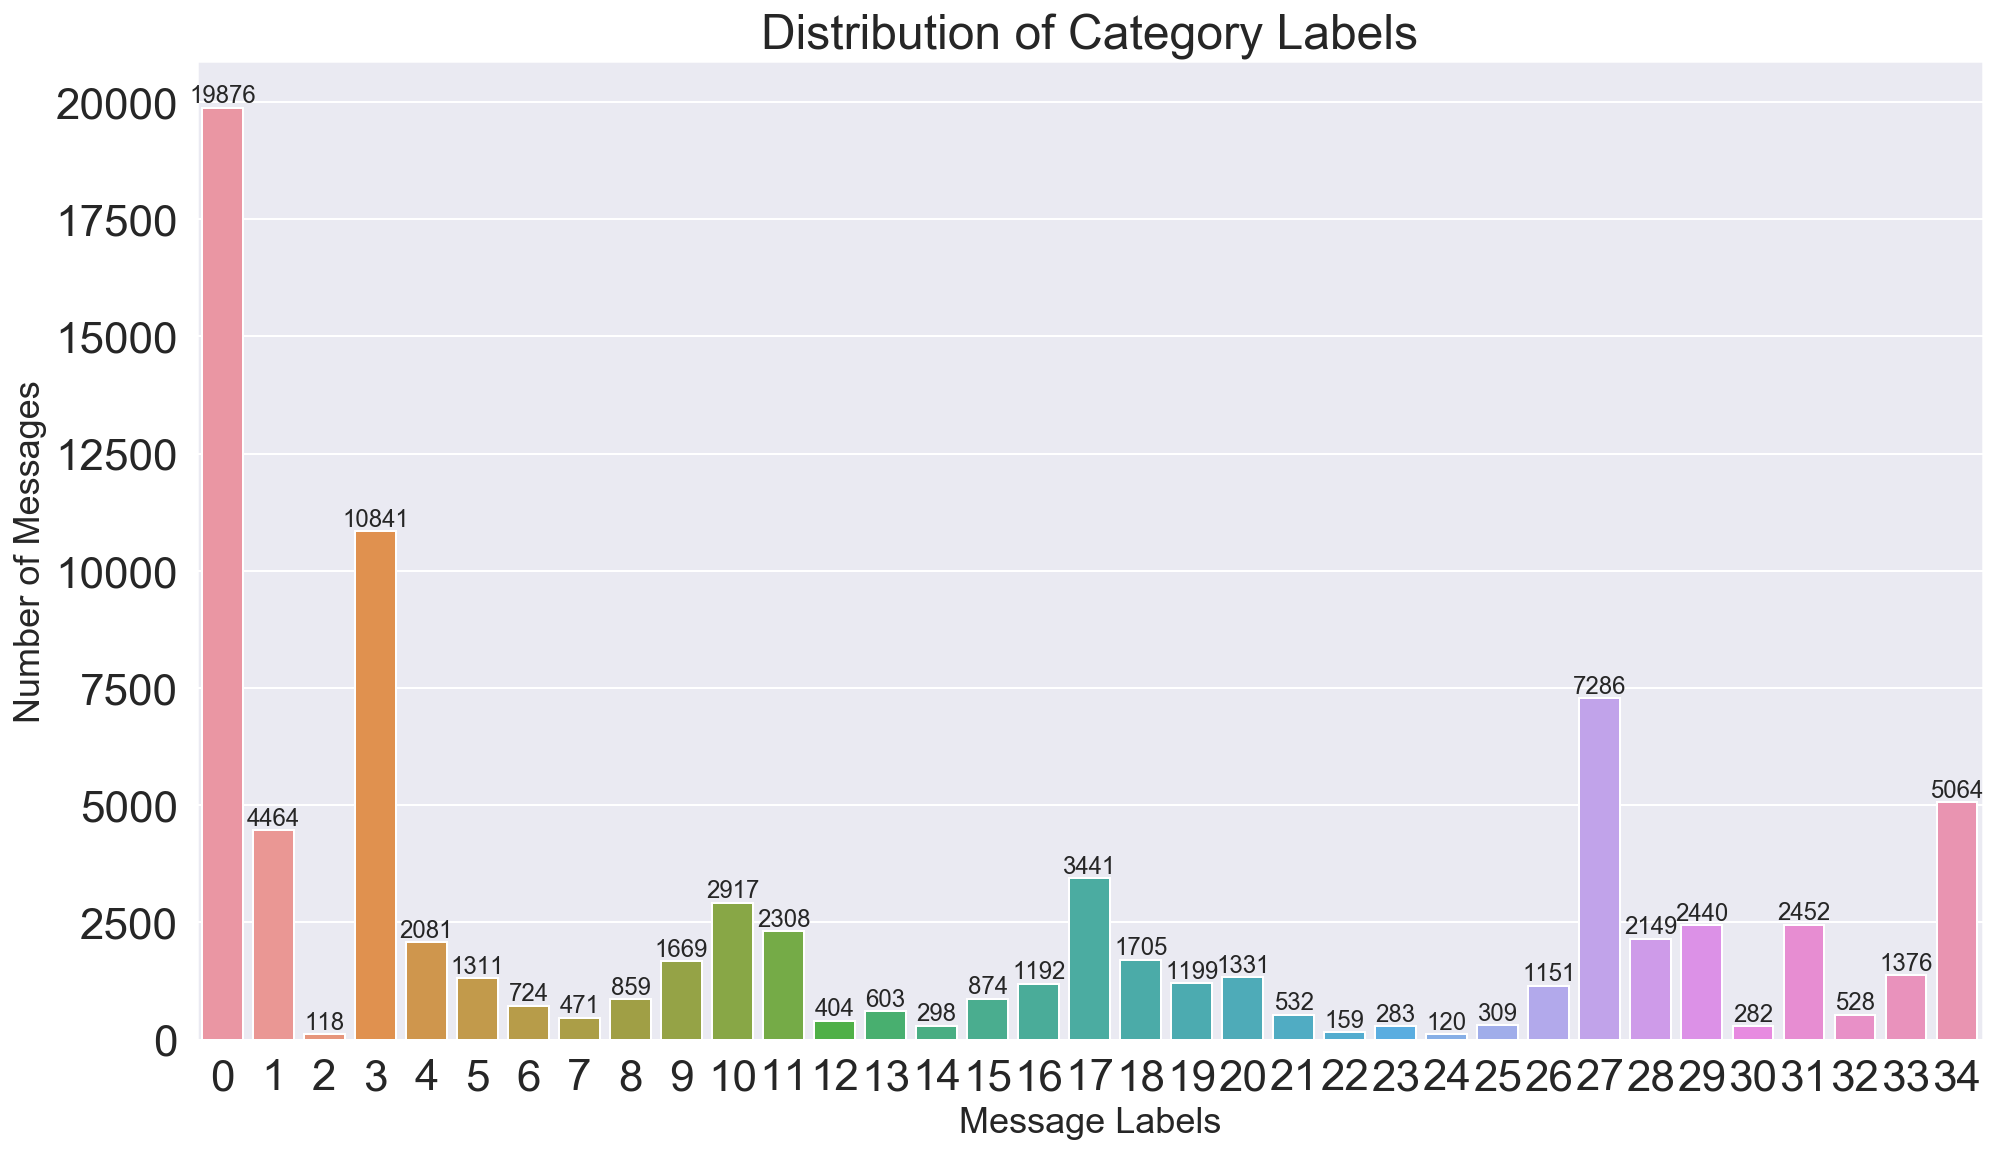

In [605]:
model_original = ML_classifier()
model_original.plot_dist(df)

In [606]:
model_original.fit(df)
model_original.evaluate()
report_original = model_original.report
report_orginal[(report_orginal['precision'] == 0.0) | (report_original.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
offer,0.000000,0.000000,0.000000,41.0
security,0.000000,0.000000,0.000000,132.0
tools,0.000000,0.000000,0.000000,34.0
hospitals,0.000000,0.000000,0.000000,94.0
shops,0.000000,0.000000,0.000000,36.0
aid_centers,0.000000,0.000000,0.000000,88.0
macro avg,0.623246,0.230912,0.296339,24501.0


We see the overal accuracy is only 62%. And in several categories, f1-scores are zero! This is mostly due the fact that majority of messages in these categories have label 0. Hence the classifier tend to label all messages with 0.

### Simple sampling method

As we can see before the dataset is very imbalanced. A lot of categories only have very few labels. Now we try to upsample those sparse samples. It is a little bit tricky though. For example a message may have labels which are both unpopular and popular. 

Now we first use a simple sample strategy by upsampling messages with unpopular labels, regardless of whether the message have popular labels.

In [607]:
# # first we only consider related messages
sub_cats = categories[categories['related'] == 1].drop(columns = 'related')
# counts how many positive labels within each category
label_counts = sub_cats.sum().values
criteria = label_counts/df.shape[0] < 0.05
sparse_label = list(sub_cats.columns[criteria])

Note here we set the number of bootstrap sampling to be equal to the number of messages in the most popular category.

In [608]:
upsample_num = np.sort(label_counts)[::-1][0]
msg_simple_sample = df[df[sparse_label].any(axis = 1)].sample(n = upsample_num, replace = True, random_state = 0)
df_simple_sample = pd.concat([msg_simple_sample, df[~df[sparse_label].any(axis = 1)]])

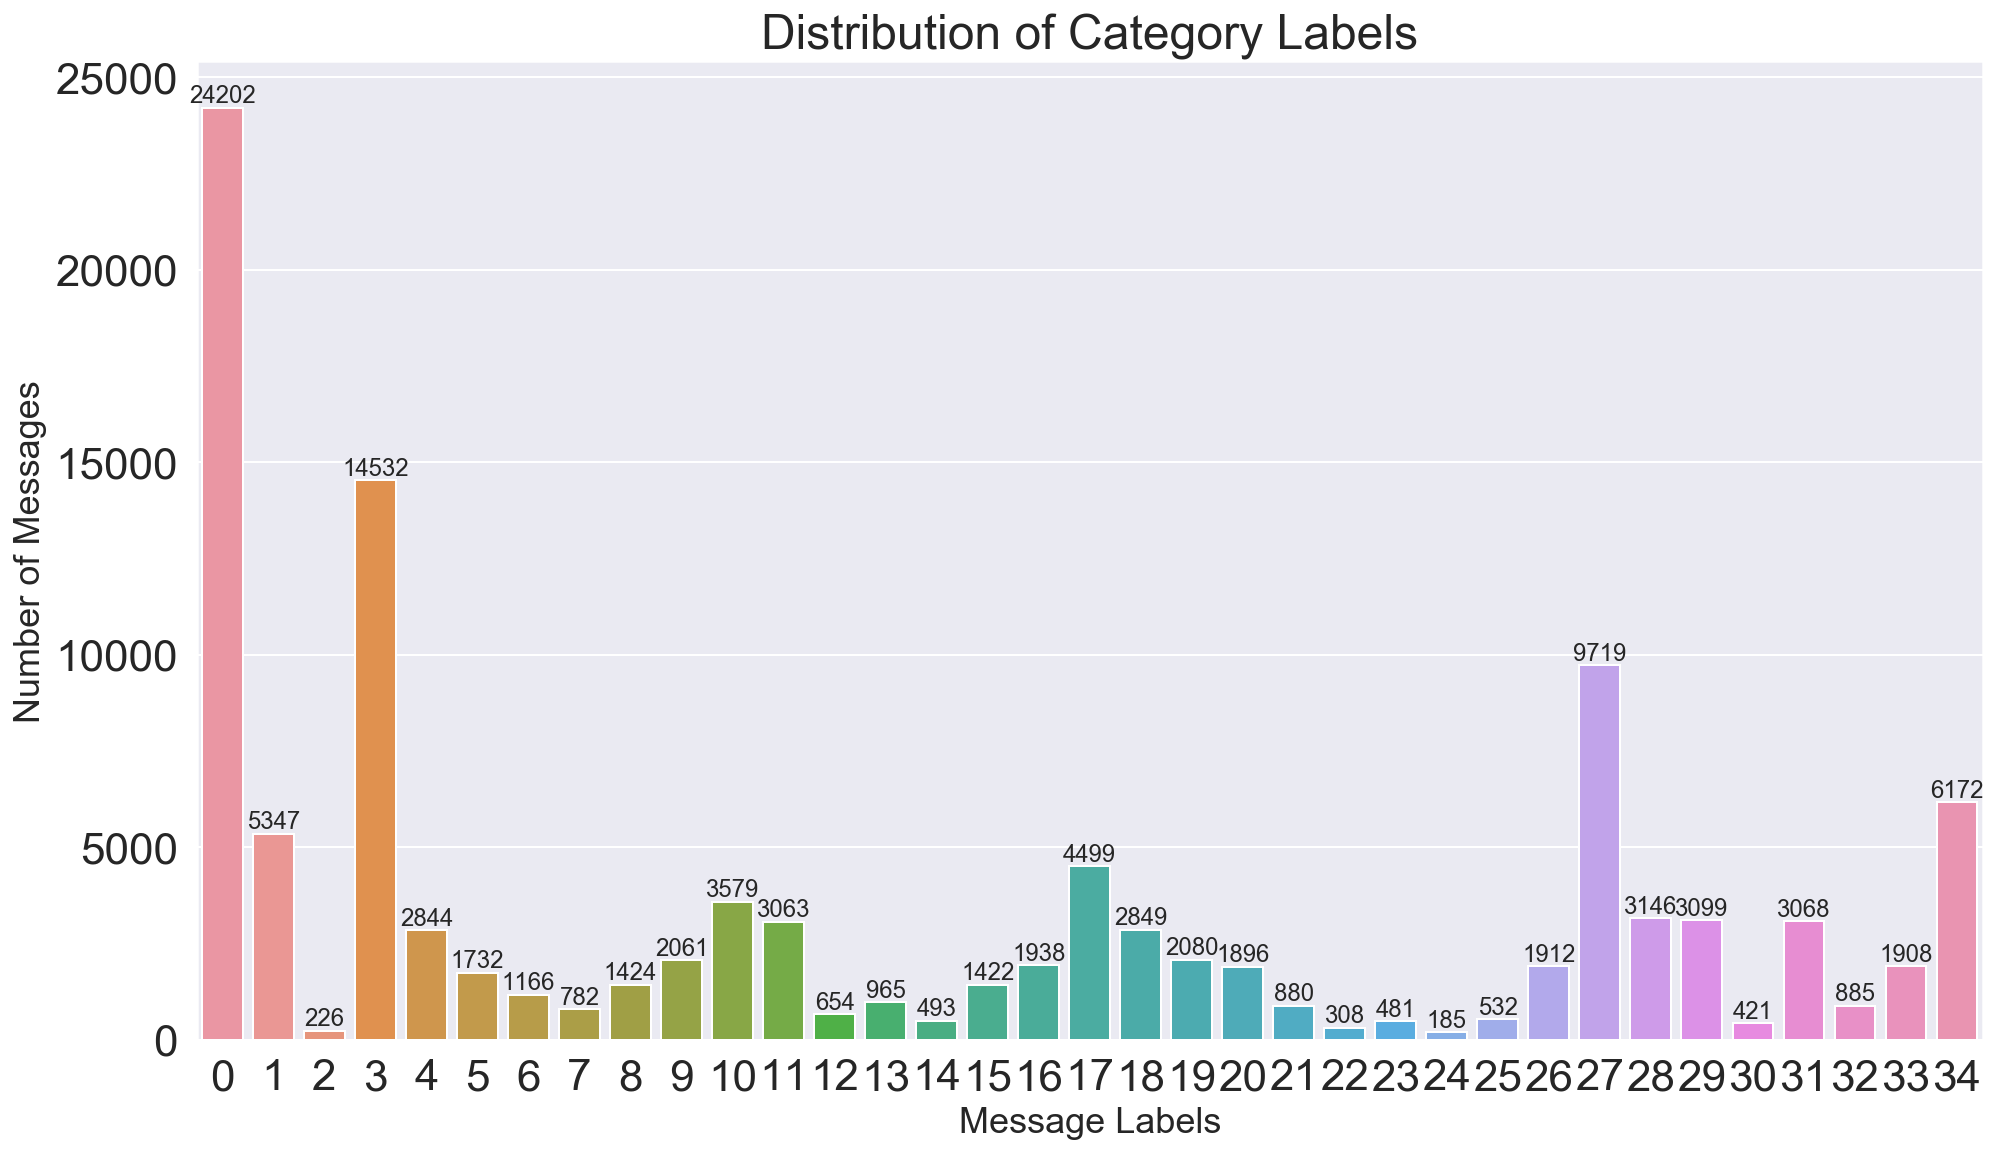

In [609]:
model_simple_sample = ML_classifier()
model_simple_sample.plot_dist(df_simple_sample)

In [599]:
model_simple_sample.fit(df_simple_sample)
model_simple_sample.evaluate()

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4625121795079782

In [600]:
report_simple_sample = model_simple_sample.report
report_simple_sample[(report_simple_sample['precision'] == 0.0) | (report_simple_sample.index == 'macro avg')]

,precision,recall,f1-score,support
offer,0.000000,0.000000,0.000000,66.0
security,0.000000,0.000000,0.000000,225.0
tools,0.000000,0.000000,0.000000,87.0
shops,0.000000,0.000000,0.000000,68.0
macro avg,0.731451,0.290343,0.375491,32850.0


We can see a substantial improvement of our model by using this simple upsampling trick. The number of categories with f1-score = 0 also decreases.

### More Sophiscated Resample Strategy

We can still make progress by using a more sophiscated sampling method, i.e., only upsampling the messages with unpopular labels.

In [534]:
# we define the top-3 most labels as popular
pop_label = list(sub_cats.sum().sort_values(ascending = False)[:3].index)
# messages without any label in those popular categories 
sparse_msg = sub_cats[~sub_cats[pop_label].any(axis = 1)]
sparse_msg.sum(axis = 1).value_counts()

0    5115
1     247
2      81
3      29
4       3
5       2
dtype: int64

We see most messages actually don't get any labels. Since we want to improve our f1 score, we need to put more postive samples in our dataset. So we will only up-sample messages with at least 1 positive label within the unpopular groups.

In [535]:
# messages to be upsampled
# we exclude messages without any labels other than 'related' = 1
msg_to_sample = sparse_msg[(sparse_msg.sum(axis = 1) > 0)]

Here we again use the same up-sampling number.

In [570]:
# upsampling 
# msg_under_sample = msg_to_sample.sample(n = label_counts[0], replace = True, random_state = 0)
msg_under_sample = msg_to_sample.sample(n = upsample_num, replace = True, random_state = 0)
df_sample = pd.concat([df.loc[msg_under_sample.index], df.loc[list(set(df.index.values) - set(msg_to_sample.index.values))]])

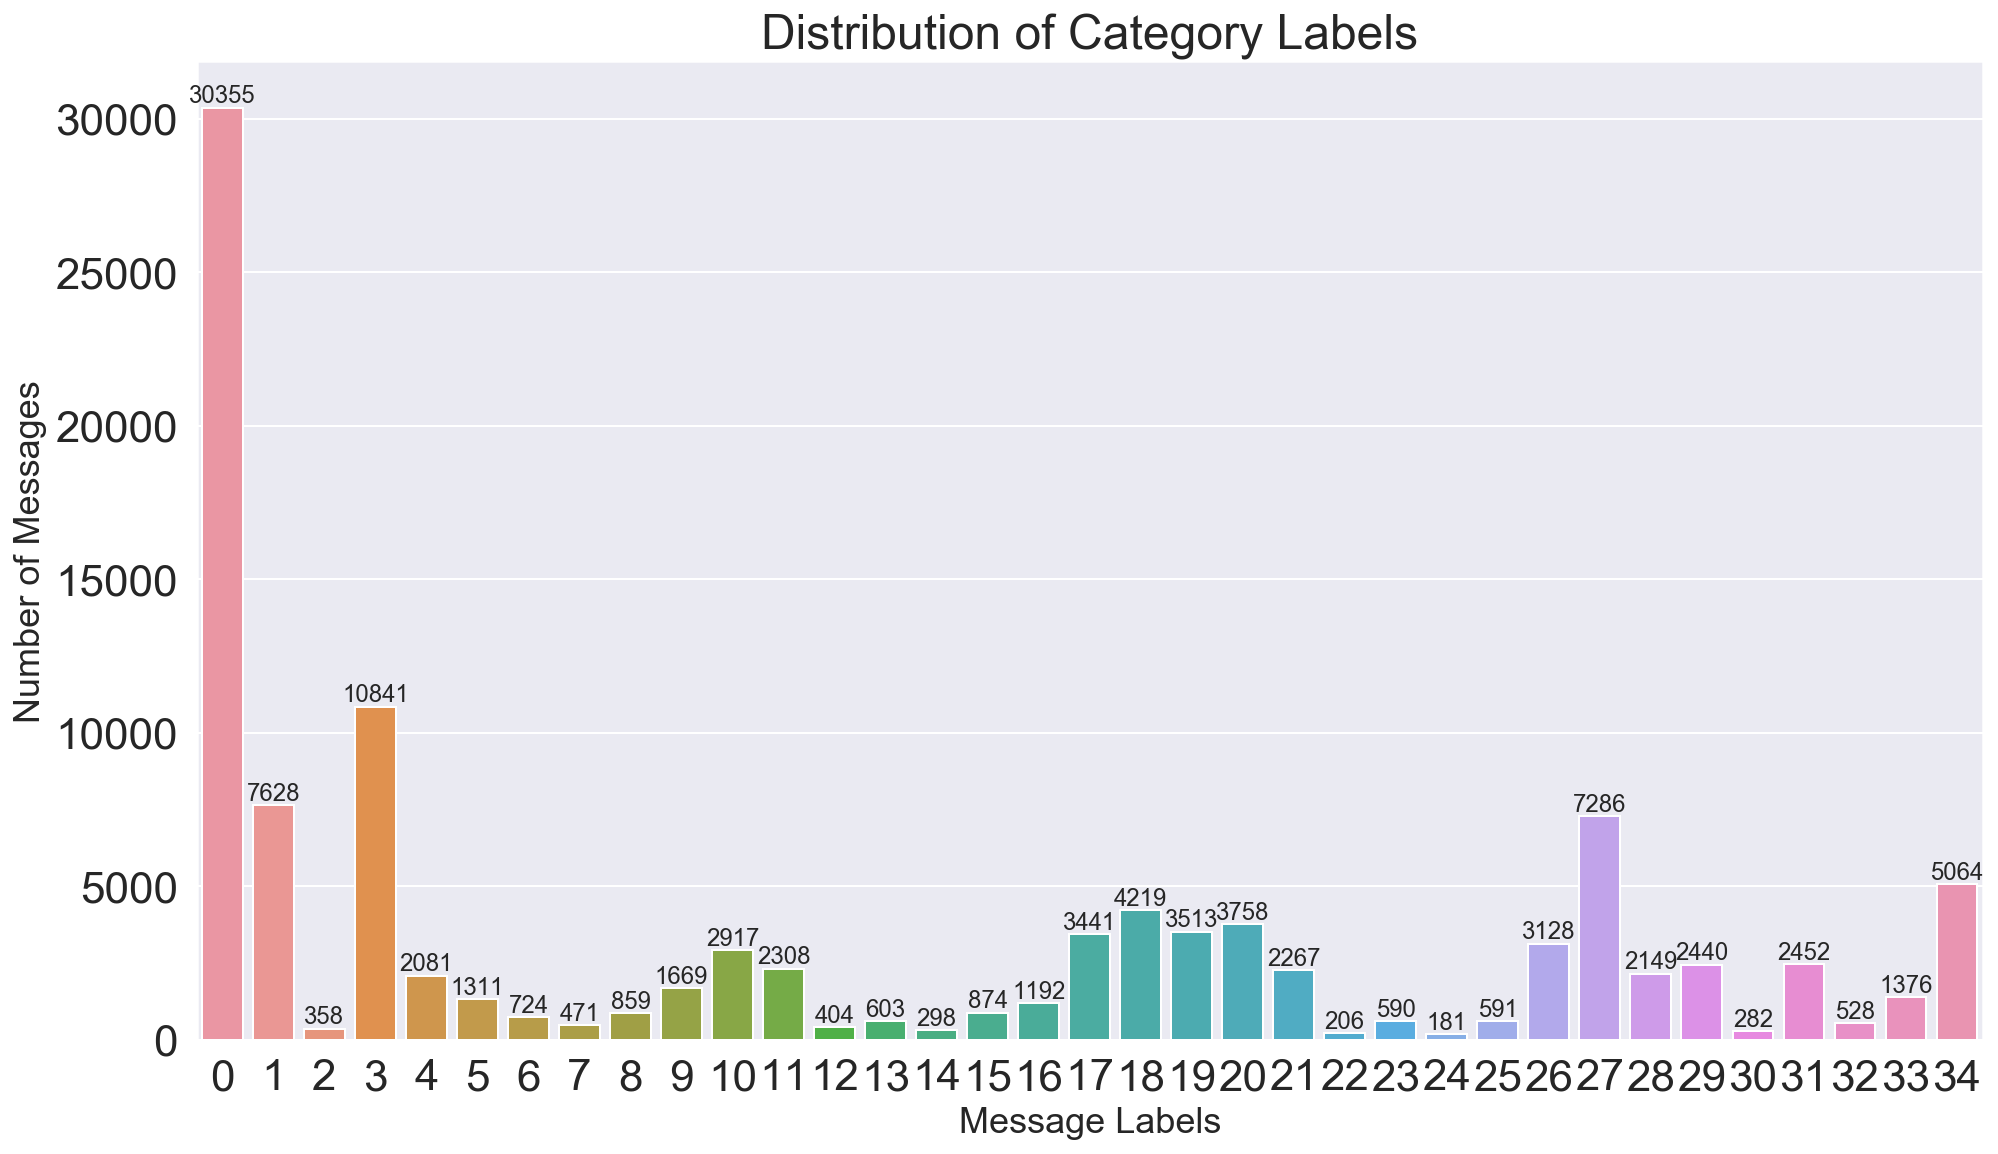

In [601]:
model_sample = ML_classifier()
model_sample.plot_dist(df_sample)

In [602]:
model_sample.fit(df_sample)
model_sample.evaluate()

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5904493996885656

In [603]:
report_sample = model_sample.report
report_sample[(report_sample['precision'] == 0.0) | (report_sample.index == 'macro avg')]

,precision,recall,f1-score,support
security,0.000000,0.000000,0.000000,144.0
macro avg,0.815204,0.373497,0.464201,32264.0


Much better!

### Upsample training set only
We see a huge performance improvement using the up-sampled dataset.
Note however there is a potential issue in the previous method. We should only sample the training set to avoid data leak.

In [582]:
df_shuffle = df.sample(frac = 1.0, replace=False, random_state = 0) # shuffle all the rows first
df_train, df_test = df_shuffle[:int(0.7*len(df_shuffle))], df_shuffle[int(0.7*len(df_shuffle)):]

In [ ]:
# first we only consider related messages
sub_df = df_train[df_train['related'] == 1].drop(columns = 'related')
categories = df_train.drop(columns = ['id', 'message', 'original', 'genre'])
sub_cats = categories[categories['related'] == 1].drop(columns = 'related')
# counts how many positive labels within each category
label_counts = sub_cats.sum().values
criteria = label_counts/df_train.shape[0] < 0.05
sparse_label = list(sub_cats.columns[criteria])

In [ ]:
# we define the top-3 most labels as popular
pop_label = list(sub_cats.sum().sort_values(ascending = False)[:3].index)
# messages without any label in those popular categories 
sparse_msg = sub_cats[~sub_cats[pop_label].any(axis = 1)]
sparse_msg.sum(axis = 1).value_counts()

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.